In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #svg
import pylab as plb # this notebook is for plotting
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['font.size'] = 7 #
plb.rcParams['font.stretch'] =  0
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
import warnings
warnings.filterwarnings('ignore')

In [2]:
!ls

01_extract_metadata.ipynb
02_apply_saccade_filter.ipynb
02_temporal_microstructure.ipynb
detected_saccades_nl_22H05.hdf5
open_loop_rotation_22H05_ptch_roll.hdf5
trial_rasters_with_examples_sorted_by_behavior.pdf
Untitled.ipynb


In [3]:
import h5py
mtd_22H05_yaw = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_22H05.hdf5','r')
mtd_39E01_yaw = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_39E01.hdf5','r')

In [4]:
#store the selected filter setting in a dictionary. Pickle for later use
import cPickle
with open('../06_saccades/chosen_filter_settings.cpkl','rb') as f:
    chosen_settings = cPickle.load(f)

import os, sys
sac_path = os.path.abspath(os.path.join('..','06_saccades'))
sys.path.append(sac_path)
import findsaccade as fsac

filtdata = fsac.filter_mtrx_nonlinear(mtd_22H05_yaw['normed_signals']['Ph0'],
                           chosen_settings['ksizes'],
                           chosen_settings['mysizes'])

sac_data = ((filtdata>chosen_settings['thresh_vals']*2) + 
            (filtdata<chosen_settings['thresh_vals']*-2)*-1)

In [5]:
saccade_tables_39E01 = h5py.File('../06_saccades/detected_saccades_nl_39E01.hdf5','r')
saccade_tables_22H05 = h5py.File('../06_saccades/detected_saccades_nl_22H05.hdf5','r')

lw_natural_22H05 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_22H05['Ph0'])* 
                      np.array(saccade_tables_22H05['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['lwing_mean'])[:,None])
    
rw_natural_22H05 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_22H05['Ph1'])* 
                      np.array(saccade_tables_22H05['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['rwing_mean'])[:,None])
    
lmr_natural_22H05 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_22H05['Ph2'])* 
                      np.array(saccade_tables_22H05['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_22H05['lmr_mean'])[:,None])
    

lw_natural_39E01 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_39E01['Ph0'])* 
                      np.array(saccade_tables_39E01['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['lwing_mean'])[:,None])
    
rw_natural_39E01 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_39E01['Ph1'])* 
                      np.array(saccade_tables_39E01['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['rwing_mean'])[:,None])
    
lmr_natural_39E01 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_39E01['Ph2'])* 
                      np.array(saccade_tables_39E01['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_39E01['lmr_mean'])[:,None])

sort_sig_22H05 = np.mean(lmr_natural_22H05[:,49:51],axis = 1) - np.mean(lmr_natural_22H05[:,:30],axis = 1)
sort_sig_39E01 = np.mean(lmr_natural_39E01[:,49:51],axis = 1) - np.mean(lmr_natural_39E01[:,:30],axis = 1)

sort_idx_22H05 = np.argsort(sort_sig_22H05,axis = 0)
sort_idx_39E01 = np.argsort(sort_sig_39E01,axis = 0)

In [6]:
#create dict of sorted trials in memory
sorted_saccades_22H05 = dict()
[sorted_saccades_22H05.update({sig:np.array(saccade_tables_22H05[sig])[sort_idx_22H05]}) for 
                                                sig in saccade_tables_22H05.keys()];
sorted_saccades_39E01 = dict()
[sorted_saccades_39E01.update({sig:np.array(saccade_tables_39E01[sig])[sort_idx_39E01]}) for 
                                                sig in saccade_tables_39E01.keys()];

In [7]:
percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_22H05 = zip(percentile_ranges_22H05[9:110:10],percentile_ranges_22H05[0:100:10])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_39E01 = zip(percentile_ranges_39E01[9:110:10],percentile_ranges_39E01[0:100:10])

In [8]:
class DivergingCMapCreator(object):
    hsv_arr = np.zeros((1,100,3))
    
    def get_sincurve(self,gam,end,cent):
        rng = np.linspace(0,np.pi,100)
        return (((np.sin(rng)**gam))*(cent-end))+(end)

    def get_sigcurve(self,k0,start,stop):
        rng = np.linspace(0,1,100)
        return (stop-start)/(1+np.exp(k0*(0.5-rng)))+start

    def set_hsvs(self,hk,hstart,hstop,
                  sgam,send,scent,
                  vgam,vend,vcent):
        self.hsv_arr[0,:,0] = self.get_sigcurve(hk,hstart,hstop)
        self.hsv_arr[0,:,1] = self.get_sincurve(sgam,send,scent)
        self.hsv_arr[0,:,2] = self.get_sincurve(vgam,vend,vcent)
        return self.hsv_arr

    def get_mpl_cmap(self):
        from matplotlib.colors import LinearSegmentedColormap
        import matplotlib.colors as mplcols
        rgb = mplcols.hsv_to_rgb(self.hsv_arr)
        in_map = np.linspace(0,1,100)
        cdict = {'red':np.vstack  ((in_map,rgb[0,:,0],rgb[0,:,0])).T,
                 'green':np.vstack((in_map,rgb[0,:,1],rgb[0,:,1])).T,
                 'blue':np.vstack ((in_map,rgb[0,:,2],rgb[0,:,2])).T,
        }
        return LinearSegmentedColormap('custom', cdict)
        
cm_creator = DivergingCMapCreator()
def plot_hsvs(hk,hstart,hstop,
                  sgam,send,scent,
                  vgam,vend,vcent):
        dta = cm_creator.set_hsvs(hk,hstart,hstop,
                      sgam,send,scent,
                      vgam,vend,vcent)
        from matplotlib import gridspec
        from scipy.misc import lena
        import plotfuncs as plf
        import matplotlib.colors as mplcols
        gs = gridspec.GridSpec(2,2)
        
        plb.subplot(gs[0,0])
        plb.plot(dta[0,:,:])
        plb.gca().set_ybound(0,1)
        plf.pull_ax_spines()
        
        plb.subplot(gs[1,0])
        plb.imshow(mplcols.hsv_to_rgb(dta),aspect = 'auto')
        plf.kill_spines()
        from scipy.misc import lena
        
        plb.subplot(gs[:,1])
        plb.imshow(lena(),cmap = cm_creator.get_mpl_cmap())

In [9]:
from ipywidgets import interact

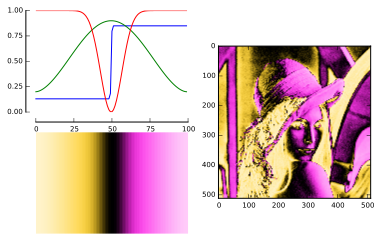

In [10]:
zto = (0,1,0.1)
interact(plot_hsvs,hk = (0,1000,10),
                   hstart = (0,1,0.01),
                   hstop = (0,1,0.01),
                   sgam = (0,20,0.1),
                   send = zto,
                   scent = zto,
                   vgam = (0,20,0.1),
                   vend = zto,
                   vcent = zto)

In [11]:
custom_cm = cm_creator.get_mpl_cmap()
plb.register_cmap(cmap=custom_cm)
plb.rcParams['image.cmap'] = custom_cm.name

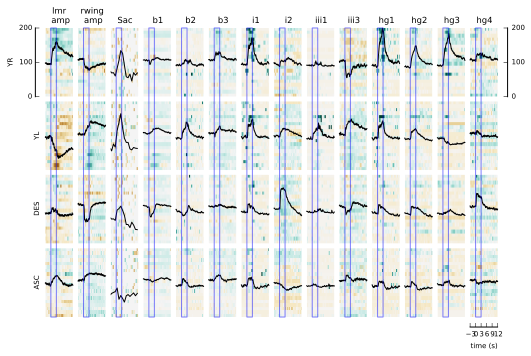

In [10]:
import plotfuncs as pf
reload(gd)
example_trial = 13
trial = 'yaw_left'

row_keys = ['yaw_left','yaw_right','ascending','descending']
col_keys= ['Ph2','Ph1','Sac','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4']

z_rng = {'Ph2':6,'Ph1':6,'Sac':1.5,'b1':6,'b2':6,'b3':6,'i1':6,'i2':6,'iii3':6,'iii1':6,'hg1':6,'hg2':6,'hg3':6,'hg4':6}
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)]
#ybounds[2] = (0,1.5)
xbounds = [(-3,12) for j in range(cols)]  

#Columns are muscles 
col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'

col_labels_top = [gd.signal_plot_info[sig]['ax_label'] for sig in col_keys]
#col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

#rows are trial types
row_labels_left = [gd.trial_to_label[trial] for trial in row_keys]

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (7.4,5)
sub_samples = 20

trial_names = np.array(mtd_22H05_yaw['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    if signal == 'Sac':
        return sac_data[selection,:]
    else:
        return np.array(mtd_22H05_yaw['normed_signals'][signal][selection,:])
    
def plot_sac_mtrx(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_22H05:
        top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_22H05['row'] == rownum
                raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)

    plb.imshow(sac_raster,vmin = -1,vmax =1,extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    plb.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
    
import copy

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    #if col > 0:
    signal = col_keys[col]
    trial = row_keys[row]
    if signal == 'Sac':
        plot_sac_mtrx(trial)
    else:
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',
                     extent = (xi[0],xi[-1],0,200),
                     vmin = -z_rng[signal],
                     vmax = z_rng[signal],
                     interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')

#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

def selfish_change_y(ax):
    try:
        ax.share_y = None;ax._shared_y_axes = None
        ax.set_ybound(0,1.5)
    except AttributeError:
        pass
    
for ax in ax_grid:
    selfish_change_y(ax[2])

In [35]:
mtd_22H05_yaw['signal_means'].keys()

[u'Ph0',
 u'Ph1',
 u'Ph2',
 u'StimCond',
 u'Xpos',
 u'Ypos',
 u'b1',
 u'b2',
 u'b3',
 u'hg1',
 u'hg2',
 u'hg3',
 u'hg4',
 u'i1',
 u'i2',
 u'iii1',
 u'iii24',
 u'iii3',
 u'nm',
 u'pr',
 u'tpd',
 u'tpv',
 u'ttm',
 u'wb_frequency']

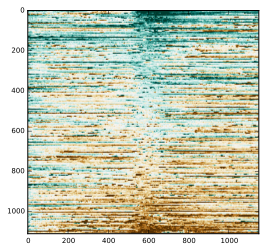

In [108]:
signal = 'Ph2'

trnsfrm =  ((np.array(mtd_22H05_yaw['normed_signals'][signal]) +
            np.array(mtd_22H05_yaw['signal_means'][signal])[:,None]) *
            np.array(mtd_22H05_yaw['signal_norms'][signal])[:,None])
trnsfrm = gd.signal_plot_info[signal]['transform'](trnsfrm)

ssig = np.argsort(np.mean(trnsfrm[:,stim_ep],axis = 1))[::-1]
vmid = np.mean(trnsfrm[:,stim_ep])
vdelta = 2*np.std(trnsfrm[:,stim_ep])
plb.imshow(trnsfrm[ssig],vmin = vmid-vdelta,vmax = vmid+vdelta)

In [109]:
vdelta

26.690478366734535

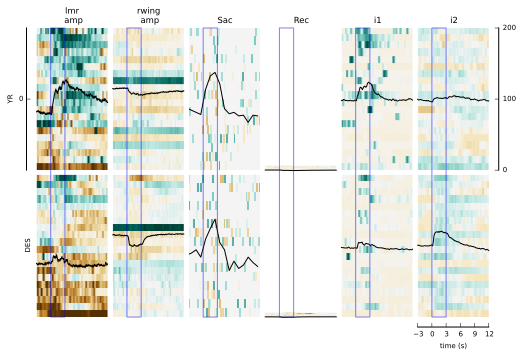

In [110]:
import plotfuncs as pf
reload(gd)
example_trial = 13
trial = 'yaw_left'

row_keys = ['yaw_left','ascending']
col_keys= ['Ph2','Ph1','Sac','recon','i1','i2']

z_rng = {'Ph2':30,'Ph1':65,'Sac':1.5,'recon':6, 
         'b1':6,'b2':6,'b3':6,'i1':6,'i2':6,'iii3':6,'iii1':6,'hg1':6,'hg2':6,'hg3':6,'hg4':6}

z_m = {'Ph2':0,'Ph1':40,'Sac':0,'recon':0, 
         'b1':0,'b2':0,'b3':0,'i1':0,'i2':0,'iii3':0,'iii1':0,'hg1':0,'hg2':0,'hg3':0,'hg4':0}

pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)]
#ybounds[0] = (0,90)
#ybounds[2] = (0,1.5)
xbounds = [(-3,12) for j in range(cols)]  

#Columns are muscles 
col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'

col_labels_top = [gd.signal_plot_info[sig]['ax_label'] for sig in col_keys]
#col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

#rows are trial types
row_labels_left = [gd.trial_to_label[trial] for trial in row_keys]

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (7.4,5)
sub_samples = 20

trial_names = np.array(mtd_22H05_yaw['selected_signals']['trial_names'])[ssig]
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    if signal == 'Sac':
        return sac_data[ssig][selection,:]
    elif signal == 'recon':
        return reconst[ssig][selection,:]
    elif signal in ['Ph2','Ph1','Ph0']:
        trnsfrm =  ((np.array(mtd_22H05_yaw['normed_signals'][signal])[ssig][selection,:] +
                    np.array(mtd_22H05_yaw['signal_means'][signal])[ssig][selection][:,None]) *
                    np.array(mtd_22H05_yaw['signal_norms'][signal])[ssig][selection][:,None])
        return gd.signal_plot_info[signal]['transform'](trnsfrm)
    else:
        return np.array(mtd_22H05_yaw['normed_signals'][signal])[ssig][selection,:]
    
def plot_sac_mtrx(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_22H05:
        top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_22H05['row'] == rownum
                raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)

    plb.imshow(sac_raster*-1,vmin = -1,vmax =1,extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    plb.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
    
import copy

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    #if col > 0:
    signal = col_keys[col]
    trial = row_keys[row]
    if signal == 'Sac':
        plot_sac_mtrx(trial)
    else:
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',
                     extent = (xi[0],xi[-1],z_m[signal] - z_rng[signal],
                                            z_m[signal] + z_rng[signal]),
                     vmin = z_m[signal] - z_rng[signal],
                     vmax = z_m[signal] + z_rng[signal],
                     interpolation = 'nearest')
        sig = np.nanmean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx],clip_on = False,color = 'k')

#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

def selfish_change_y(ax,ymin,ymax):
    try:
        ax.share_y = None;ax._shared_y_axes = None
        ax.set_ybound(ymin,ymax)
    except AttributeError:
        pass
    
for ax in ax_grid:
    selfish_change_y(ax[0],z_m['Ph2']+z_rng['Ph2'],
                           z_m['Ph2']-z_rng['Ph2'])
    selfish_change_y(ax[1],z_m['Ph1']+z_rng['Ph1'],
                           z_m['Ph1']-z_rng['Ph1'])
    selfish_change_y(ax[2],0,1.2)
    
    selfish_change_y(ax[4],z_m['i1']+z_rng['i1'],
                           z_m['i1']-z_rng['i1'])
    if type(ax[5]) is list:
        selfish_change_y(ax[5][0],z_m['i2']+z_rng['i2'],
                           z_m['i2']-z_rng['i2'])
    else:
        selfish_change_y(ax[5],z_m['i2']+z_rng['i2'],
                           z_m['i2']-z_rng['i2'])


In [14]:
trace1 = np.array(mtd_22H05_yaw['normed_signals']['Ph1'][0])

In [101]:
vmid

44.249109898307658

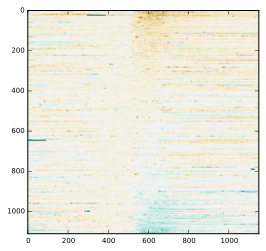

In [84]:
plb.imshow(trnsfrm[np.argsort(sort_sig)] - 
           np.mean(trnsfrm[np.argsort(sort_sig)][:,prestim_ep],axis =1)[:,None])

In [13]:
xi = gd.get_xio('yaw_left')
stim_ep = (xi>0) & (xi<3)
prestim_ep = (xi>-3) & (xi<0)

In [14]:
fly_set = list(set(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])))

In [15]:
#mmtrx = np.array(msigs[:,prestim_ep,:])
#fly_selection = np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly_set[i]
#fly_selection = np.array([fly_selection])
#np.shape(mmtrx*fly_selection[:,None,None])

In [16]:
muscles = ['b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4']
msigs = np.dstack(mtd_22H05_yaw['normed_signals'][key] for key  in muscles)
rwing = np.array(mtd_22H05_yaw['normed_signals']['Ph1'])
lwing = np.array(mtd_22H05_yaw['normed_signals']['Ph0'])
lmr = np.array(mtd_22H05_yaw['normed_signals']['Ph2'])

In [17]:
np.shape(msigs)

(1111, 1150, 11)

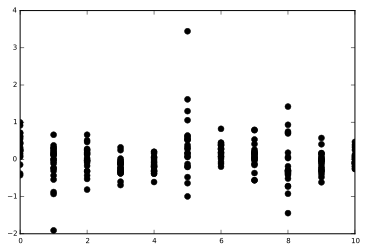

In [18]:
#from mpl_toolkits.mplot3d import Axes3D
#ax = plb.axes(projection='3d')
#ax.view_init(30, angle)
fly_dict = dict()
xmtrx = np.zeros_like(msigs)
for fly in fly_set:
    fly_selection = np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly
    mmtrx = np.array([msigs[fly_selection][:,prestim_ep,:][:,:,i].ravel() for i in range(11)]) 
    output = rwing[fly_selection][:,prestim_ep].ravel()
    #mmtrx = np.vstack((np.ones_like(output),mmtrx))
    x,residuals,rank,s = np.linalg.lstsq(mmtrx.T,output)
    plb.plot(x,'o',color = 'k',alpha = np.sqrt(residuals[0])/100.)
    fly_dict[fly] = {'x':x,'residuals':residuals,'rank':rank}
    xmtrx[fly_selection,:,:] = x[None,None,:]
    #mmtrx -= np.nanmean(mmtrx,axis = 1)[:,None]
    #mmtrx /= np.nanstd(mmtrx,axis = 1)[:,None]
    #if not(np.sum((~(np.isfinite(mmtrx))) > 0)):
    #    U, s, Vt = scipy.linalg.svd(mmtrx.T, full_matrices=False,check_finite = True)
    #    V = Vt.T
    #    S = np.diag(s)
    #    PCs = np.dot(U[:,:3], S[:3,:3])
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],alpha = 0.5)
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],PCs[:,2][::2],alpha = 0.5)
#for i in range(len(fly_set)):
#    fly_selection = np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly_set[i]
#    mmtrx = np.array([msigs[fly_selection][:,stim_ep,:][:,:,i].ravel() for i in range(11)])
#    output = rwing[fly_selection][:,prestim_ep].ravel()
#    x,residuals,rank,s = np.linalg.lstsq(mmtrx.T,output)
#    #print residuals
#    plb.plot(x,'o',color = 'r',alpha = np.sqrt(residuals[0])/100.)
    #mmtrx -= np.nanmean(mmtrx,axis = 1)[:,None]
    #mmtrx /= np.nanstd(mmtrx,axis = 1)[:,None]
    #if not(np.sum((~(np.isfinite(mmtrx))) > 0)):
    #    U, s, Vt = scipy.linalg.svd(mmtrx.T, full_matrices=False,check_finite = True)
    #    V = Vt.T
    #    S = np.diag(s)
    #    PCs = np.dot(U[:,:3], S[:3,:3])
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],alpha = 0.5)
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],PCs[:,2][::2],alpha = 0.5)

In [19]:
reconst = np.sum(msigs*xmtrx,axis = 2)

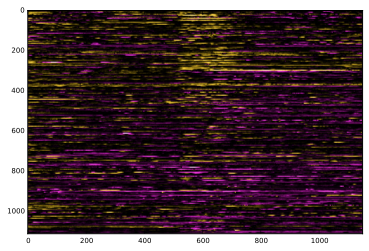

In [57]:
plb.imshow(reconst,aspect = 'auto',vmin = -6,vmax = 6)

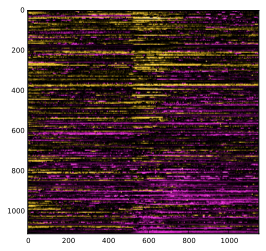

In [58]:
plb.imshow(mtd_22H05_yaw['normed_signals']['Ph1'])

In [144]:
## i = 0
import scipy
output_sig = 'Ph1'
muscles = ['b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4']
#tidxs = np.squeeze(np.argwhere(np.array(mtd_22H05_yaw['selected_signals']['trial_names']) == 'yaw_left'))
from mpl_toolkits.mplot3d import Axes3D
#ax = plb.axes(projection='3d')
for i in tidxs:
    output = mtd_22H05_yaw['normed_signals'][output_sig][i]
    msigs = np.vstack(mtd_22H05_yaw['normed_signals'][key][i] for key  in muscles)
    #msigs -= np.nanmean(msigs,axis = 1)[:,None]
    #msigs /= np.nanstd(msigs,axis = 1)[:,None]
    if not(np.sum((~(np.isfinite(msigs))) > 0)):
        #try:
        U, s, Vt = scipy.linalg.svd(msigs[:,prestim_ep].T, full_matrices=False,check_finite = True)
        V = Vt.T
        #Vt = np.dot(V,S)
        # PCs are already sorted by descending order 
        # of the singular values (i.e. by the
        # proportion of total variance they explain)
        S = np.diag(s)
        PCs = np.dot(U, S)
        #plb.subplot(3,1,1)
        #plb.plot(PCs[:,0],output,color = 'k',alpha = 0.1)
        #plb.plot(PCs[stim_ep,0],output[stim_ep],color = 'r',alpha = 0.2)
        #plb.plot(Vt[0],'o',color = 'k',alpha = 0.01)
        #plb.subplot(3,1,2)
        #plb.plot(PCs[:,1],output,color = 'k',alpha = 0.1)
        #plb.plot(PCs[stim_ep,1],output[stim_ep],color = 'r',alpha = 0.2)
        #plb.plot(Vt[1],'o',color = 'k',alpha = 0.01)
        #plb.subplot(3,1,3)
        #plb.plot(PCs[:,2],output,color = 'k',alpha = 0.1)
        #plb.plot(PCs[stim_ep,2],output[stim_ep],color = 'r',alpha = 0.2)
        #plb.plot(Vt[2],'o',color = 'k',alpha = 0.01)
    #except Exception:
    #    pass

In [ ]:
np.shape(tidxs)

In [904]:
Mhat2 = np.dot(U[:, :3], np.dot(S[:3, :3], V[:,:3].T))

In [907]:
PCs = np.dot(U, S)

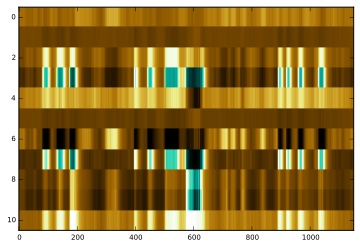

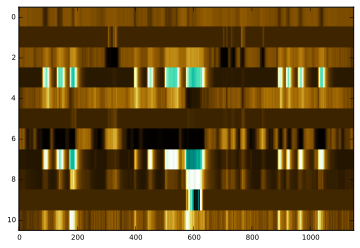

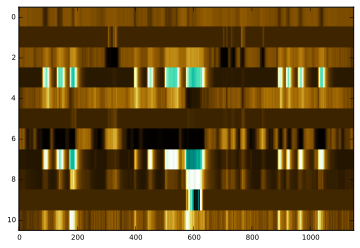

In [867]:
plb.imshow(Mhat2,aspect = 'auto')
plb.figure()
plb.imshow(Mhat,aspect = 'auto')
plb.figure()
plb.imshow(msigs,aspect = 'auto')

In [827]:
first_3_pcs

array([[ 0.04366157,  0.19608806,  0.4528998 , -0.17743735, -0.09073775,
         0.11142933,  0.31146576, -0.12217743, -0.30043237,  0.69515162,
        -0.1302207 ],
       [-0.04241898, -0.11035469, -0.08544354,  0.11210884, -0.01368532,
        -0.13417623,  0.11630083,  0.47103837, -0.82364427, -0.18380008,
         0.0196864 ],
       [ 0.22561085,  0.23353426, -0.12321786, -0.38047231,  0.08332813,
         0.77395538,  0.07167036, -0.01467652, -0.14227019, -0.27530326,
         0.16517998]])

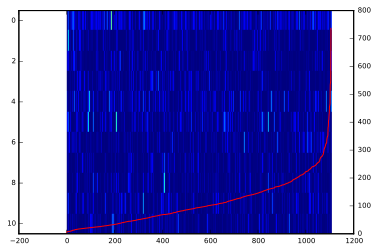

In [729]:
res_change = dta/fmres
sidx = np.argsort(fmres)
plb.imshow(res_change[:,sidx],aspect = 'auto',cmap = plb.cm.jet)
plb.twinx()
plb.plot(fmres[sidx],color = 'r')

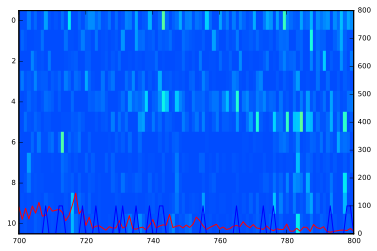

In [786]:
#plb.figure(figsize = (50,2))
fly_sort = np.argsort(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']))
ttype = (np.array(mtd_22H05_yaw['selected_signals']['trial_names']) == 'ascending').astype(float) *100

plb.imshow(res_change[:,fly_sort],aspect = 'auto',cmap = plb.cm.jet,vmin = 0,vmax = 5)
#plb.gca().set_xbound(400,600)
plb.twinx()
plb.plot(fmres[fly_sort],color = 'r')
plb.plot(ttype[fly_sort])
plb.gca().set_xbound(700,800)

In [737]:
np.array(mtd_22H05_yaw['selected_signals']

array([[ 0.01401828,  0.0140236 ,  0.01401959, ...,  0.01405454,
         0.0140548 ,  0.01405518],
       [ 0.0119499 ,  0.01192948,  0.01192581, ...,  0.01196388,
         0.01195335,  0.01196435],
       [ 0.01448682,  0.01446623,  0.01446259, ...,  0.01446407,
         0.01446647,  0.01446548],
       ..., 
       [ 0.01451274,  0.01449179,  0.01450831, ...,  0.01449493,
         0.01449934,  0.01450049],
       [ 0.01448944,  0.01448428,  0.01447388, ...,  0.01447854,
         0.0144833 ,  0.01447938],
       [ 0.01449396,  0.01452261,  0.01453888, ...,  0.01450694,
         0.01449764,  0.01449971]])

In [731]:
mtd_22H05_yaw['selected_signals'].keys()

[u'Ph0',
 u'Ph1',
 u'Ph2',
 u'StimCond',
 u'Xpos',
 u'Ypos',
 u'b1',
 u'b2',
 u'b3',
 u'exp_names',
 u'fly_numbers',
 u'genotypes',
 u'hg1',
 u'hg2',
 u'hg3',
 u'hg4',
 u'i1',
 u'i2',
 u'iii1',
 u'iii24',
 u'iii3',
 u'nm',
 u'pr',
 u'swarm_names',
 u'tpd',
 u'tpv',
 u'trial_names',
 u'trial_numbers',
 u'trial_times',
 u'ttm',
 u'wb_frequency']

In [8]:
import plotfuncs as plf
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['b3'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
            #print rowcount
    c = plb.cm.BrBG(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50,lw = 3,facecolor = 'None')
plb.gca().set_xbound(0,1000)
plb.gca().set_ybound(-1,20)
plf.pull_ax_spines()

NameError: name 'selection_rows' is not defined

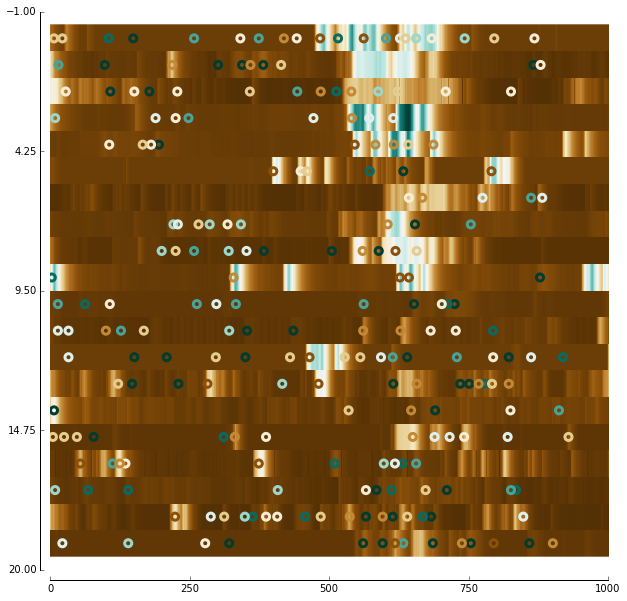

In [363]:
import plotfuncs as plf
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['i1'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
            #print rowcount
    c = plb.cm.BrBG(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50,lw = 3,facecolor = 'None')
plb.gca().set_xbound(0,1000)
plb.gca().set_ybound(-1,20)
plf.pull_ax_spines()

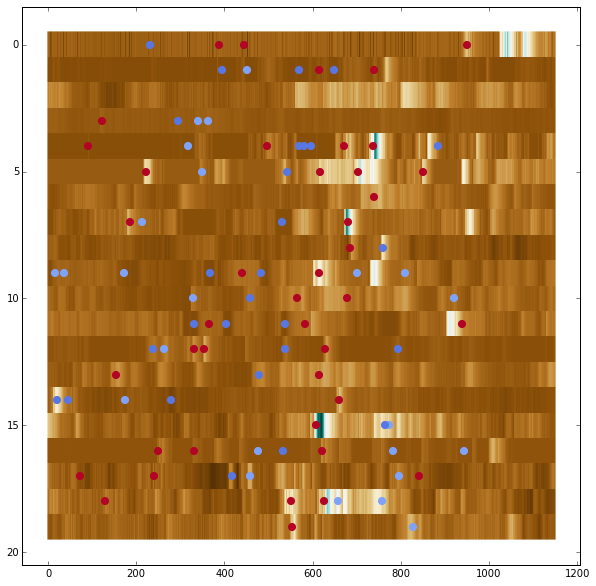

In [427]:
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['b2'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
histdata = dict()

for top_start,top_stop in [decile_brackets_22H05[x] for x in [0,1,-2,-1]]:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_right'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
    c = plb.cm.coolwarm(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50)
    xi = gd.get_xio('yaw_left')
    bins = np.arange(xi[0],xi[-1],1)
    vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
    histdata[decile] = (vals,bins)
    decile += 1


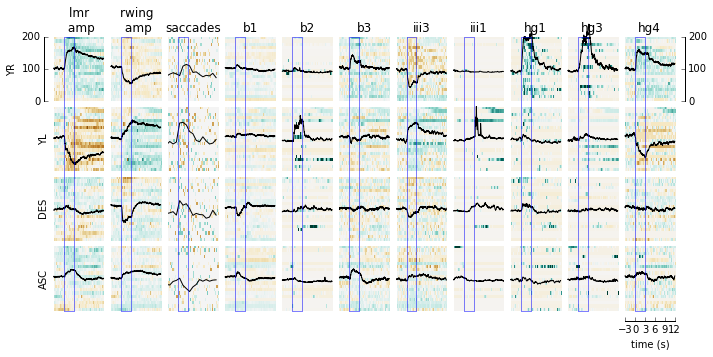

In [650]:
import plotfuncs as pf
reload(gd)
example_trial = 13
trial = 'yaw_left'

row_keys = ['yaw_left','yaw_right','ascending','descending']
col_keys= ['Ph2','Ph1','Sac','b1','b2','b3','iii3','iii1','hg1','hg3','hg4']

z_rng = {'Ph2':6,'Ph1':6,'Sac':1.5,'b1':6,'b2':6,'b3':6,'iii1':6,'iii3':6,'hg1':6,'hg3':6,'hg4':6}
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)]
#ybounds[2] = (0,1.5)
xbounds = [(-3,12) for j in range(cols)]  

#Columns are muscles 
col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'

col_labels_top = [gd.signal_plot_info[sig]['ax_label'] for sig in col_keys]
#col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

#rows are trial types
row_labels_left = [gd.trial_to_label[trial] for trial in row_keys]

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (10,5)
sub_samples = 20

trial_names = np.array(mtd_39E01_yaw['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    if signal == 'Sac':
        return sac_data[selection,:]
    else:
        return np.array(mtd_39E01_yaw['normed_signals'][signal][selection,:])
    
def plot_sac_mtrx(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_39E01:
        top_mask = (np.arange(len(sorted_saccades_39E01['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_39E01['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_39E01['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_39E01['row'] == rownum
                raster_rows[sorted_saccades_39E01['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_39E01['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_39E01['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)

    plb.imshow(sac_raster,vmin = -1,vmax =1,extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    plb.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
    
import copy

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    #if col > 0:
    signal = col_keys[col]
    trial = row_keys[row]
    if signal == 'Sac':
        plot_sac_mtrx(trial)
    else:
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',
                     cmap = plb.cm.BrBG,
                     extent = (xi[0],xi[-1],0,200),
                     vmin = -z_rng[signal],
                     vmax = z_rng[signal],
                     interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')


#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

def selfish_change_y(ax):
    try:
        ax.share_y = None;ax._shared_y_axes = None
        ax.set_ybound(0,1.5)
    except AttributeError:
        pass
    
for ax in ax_grid:
    selfish_change_y(ax[2])

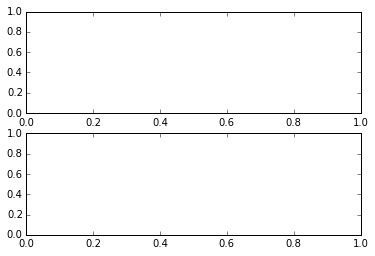

In [614]:
ax = plb.subplot(2,1,1)
ax2 = plb.subplot(2,1,2,sharex = ax)
ax._shared_y_axes

In [620]:
ax2._sharex

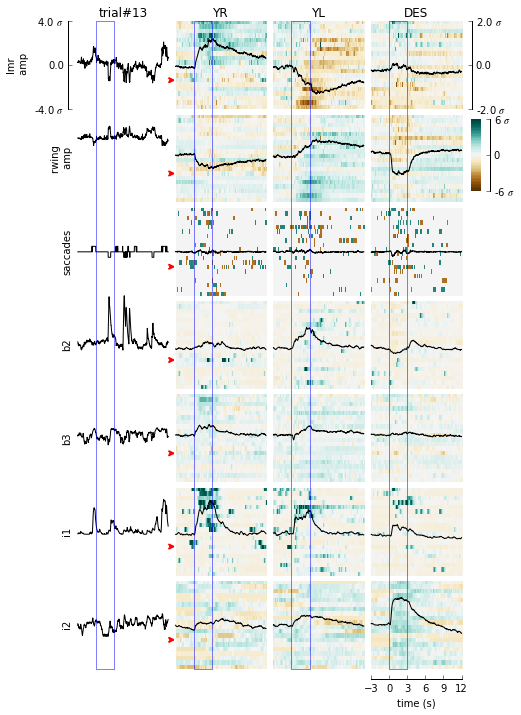

In [366]:
#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
plb.gcf().add_axes(rect)
plb.gca().yaxis.set_label_position("right")
plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
plb.yticks(np.linspace(-4,4,3))
plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng['Ph1']),'0',u'%s $\u03C3$'%(z_rng['Ph1'])])
pf.kill_spines()
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))

plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in np.linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)

lbax = ax_grid[0][0]
new_labels = [str(x) for x in np.linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels)

arrow_vpos = 200-(200/sub_samples)*example_trial - 4

import matplotlib
for row in ax_grid:
    plb.sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    plb.gca().add_patch(arr)

plb.draw()
plb.savefig('trial_rasters_with_examples_sorted_by_behavior.pdf')

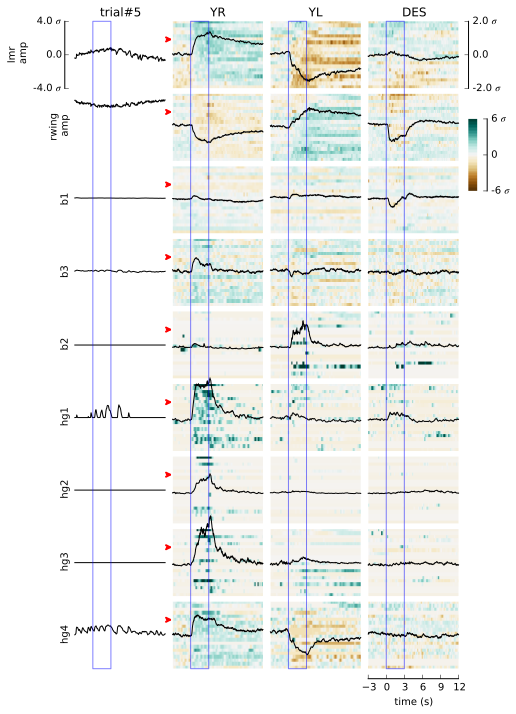

In [10]:
import plotfuncs as pf

example_trial = 5
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right','ascending']
row_keys = ['Ph2','Ph1','b1','b3','b2','hg1','hg2','hg3','hg4']

z_rng = 6
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)+1

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [gd.trial_to_label[trial] for trial in col_keys]
col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (6.85039,10)
sub_samples = 20

trial_names = np.array(mtd_39E01['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    return np.array(mtd_39E01['normed_signals'][signal][selection,:])

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    if col > 0:
        signal = row_keys[row]
        trial = col_keys[col-1]
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',cmap = plb.cm.BrBG,extent = (xi[0],xi[-1],0,200),
              vmin = -z_rng,vmax = z_rng,interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')
        
    if col == 0:
        signal = row_keys[row]
        trial = col_keys[col]
        data_selection = get_selection_mtrx(signal,trial)
        xi = gd.get_xio('yaw_left')
        ### to re-introduce natural units.        
        selection = trial_names == trial
        mns = mtd_39E01['signal_means'][signal][selection]
        stds =  mtd_39E01['signal_norms'][signal][selection]
        data_selection *= stds[:,None]
        data_selection += mns[:,None]
        
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        sig = data_selection[down_samp_idx,:][example_trial]
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(100/8.0) + 100,clip_on = False,color = 'k')

#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
plb.gcf().add_axes(rect)
plb.gca().yaxis.set_label_position("right")
plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
plb.yticks(np.linspace(-4,4,3))
plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng),'0',u'%s $\u03C3$'%(z_rng)])
pf.kill_spines()
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))

plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in np.linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)

lbax = ax_grid[0][0]
new_labels = [str(x) for x in np.linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels)

arrow_vpos = 200-(200/sub_samples)*example_trial - 4

import matplotlib
for row in ax_grid:
    plb.sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    plb.gca().add_patch(arr)

plb.draw()
plb.savefig('trial_rasters_with_examples_sorted_by_behavior_39E01.pdf')